## Score_mode predictions

In [102]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error as MSE
import matplotlib.pyplot as plt

In [103]:
#loading the data
dataframe = pd.read_csv('phase_3_TRAIN_7d499bff69ca69b6_6372c3e_MLPC2021_generic-1.csv')
target = dataframe['score_mode']
minor = dataframe['midlevel_features_minorness']
testframe = dataframe[['librosa_bpm', 'essentia_spectral_centroid_mean', 'essentia_spectral_centroid_stdev', 'librosa_spectral_bandwidth_mean']].copy()

dataframe = dataframe.drop(['id', 'score_mode', 'midlevel_features_minorness'], axis=1)

#split into train and test
split = int(len(dataframe)*0.8)
train_x = dataframe[:split]
train_y = target[:split]
test_x = dataframe[split:]
test_y = target[split:]

train_minor = minor[:split]
test_minor = minor[split:]
dataframe

,essentia_dissonance_mean,essentia_dissonance_stdev,essentia_dynamic_complexity,essentia_loudness,essentia_onset_rate,essentia_pitch_salience_mean,essentia_pitch_salience_stdev,essentia_spectral_centroid_mean,essentia_spectral_centroid_stdev,essentia_spectral_complexity_mean,...,midlevel_features_melody,midlevel_features_articulation,midlevel_features_rhythm_complexity,midlevel_features_rhythm_stability,midlevel_features_dissonance,midlevel_features_tonal_stability,score_key_strength,mean_A,mean_V,quadrant
0,0.206445,0.131383,13.998791,58.329521,3.1,0.539736,0.193987,3367.790527,3684.124268,2.986095,...,0.065397,-0.029380,-0.303987,-0.053306,-0.325228,0.347745,0.795727,50.689655,2.724138,1
1,0.145753,0.057971,3.533264,75.166183,4.2,0.476832,0.123564,1395.528809,401.987610,4.181923,...,0.353040,-0.073957,-0.381182,0.120750,-0.479266,0.451572,0.844387,50.689655,2.724138,1
2,0.149111,0.059011,3.337368,82.753929,4.3,0.457741,0.132359,1318.759644,289.306152,4.303592,...,0.201885,0.016944,-0.337422,0.103853,-0.388214,0.430684,0.758119,50.689655,2.724138,1
3,0.163914,0.057474,3.078172,79.024742,4.1,0.504427,0.121134,1258.258423,262.561310,5.271147,...,0.181998,-0.019165,-0.314282,0.118872,-0.335902,0.314371,0.747180,50.689655,2.724138,1
4,0.157382,0.054116,2.682208,59.633064,3.9,0.503377,0.121658,1244.375122,260.756195,4.122828,...,0.256362,-0.151648,-0.302913,-0.002940,-0.395495,0.368037,0.710480,50.689655,2.724138,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2602,0.106072,0.048556,4.600393,71.847145,1.7,0.541098,0.146353,3761.501709,1075.834717,3.235226,...,0.357967,-0.189399,-0.294453,-0.048271,-0.518002,0.364257,0.741726,20.344828,-0.896552,3
2603,0.097130,0.045978,4.032829,81.727577,2.4,0.506956,0.129266,3283.780029,956.233765,3.852839,...,0.223821,-0.081319,-0.211686,-0.043546,-0.427122,0.318351,0.729813,20.344828,-0.896552,3
2604,0.142735,0.059378,4.094213,27.877666,0.9,0.553664,0.155784,5419.066406,1376.261963,2.230591,...,0.190541,-0.334320,-0.268202,-0.223166,-0.392003,0.249261,0.752923,20.344828,-0.896552,3
2605,0.134667,0.057092,5.675084,57.549480,1.4,0.524951,0.150398,4481.284668,1550.097534,2.498262,...,0.292983,-0.208947,-0.286899,-0.110805,-0.460086,0.320651,0.744074,20.344828,-0.896552,3


In [104]:
#link why I tried this: https://stackoverflow.com/questions/57082826/how-can-a-chromagram-file-produced-by-librosa-be-interpreted-as-a-set-of-musical

chroma = []
for i in dataframe.columns:
    if 'chroma_mean' in i:
        chroma.append(i)

chroma_frame = dataframe[chroma].copy()
chroma_frame['max'] = chroma_frame.idxmax(axis=1)
chroma_frame['max_num'] = chroma_frame['max'].apply(lambda x: x.split('_')[-1])
chroma_frame['minor_third'] = chroma_frame['max_num'].apply(lambda x: (int(x)+3)%12).astype(str)
chroma_frame['major_third'] = chroma_frame['max_num'].apply(lambda x: (int(x)+4)%12).astype(str)
chroma_frame['lib'] = 'librosa_chroma_mean_'
chroma_frame['minor_third'] = chroma_frame['lib'] + chroma_frame['minor_third']
chroma_frame['major_third'] = chroma_frame['lib'] + chroma_frame['major_third']

min_maj = []
for ind, row in chroma_frame.iterrows():
    min_col = row['minor_third']
    maj_col = row['major_third']
    if float(row[min_col]) < float(row[maj_col]):
        min_maj.append(1)
    else:
        min_maj.append(0)
ac = accuracy_(min_maj, target)

Accuracy:  0.4706559263521289


In [105]:
#check the correlation to score_mode
from scipy.stats import pearsonr
for col in dataframe.columns:
    corr, _ = pearsonr(dataframe[col], target)
    if corr < -0.1:
        print(col, corr)
    elif corr > 0.1:
        print(col, corr)
#not even one col is to some extend correlated to score_mode

### Random Forest 

In [106]:
#fit the data and make predictions
rfc = RandomForestClassifier(n_jobs = -1)
rfc.fit(train_x, train_y)
predictions = rfc.predict(test_x)
feature_importance = rfc.feature_importances_

#accuracy function
def accuracy_(predictions, target):
    correct = 0
    for pred, act in zip(predictions, target):
        if pred == act:
            correct += 1
    accuracy = correct / len(predictions)
    print('Accuracy: ', accuracy)
    return accuracy

acc = accuracy_(predictions, test_y)

Accuracy:  0.5498084291187739


In [107]:
feature_index_importance = []
for index, importance in enumerate(feature_importance):
    feature_index_importance.append([index, importance])

feature_index_importance.sort(key=lambda x: x[1])

#take only the features which are responsible for the most important 75%
'''header = train_x.columns
unimportant_features = []
current_pro = 0
for index, importance in feature_index_importance:
    current_pro += importance
    unimportant_features.append(header[index])
    if current_pro > 0.75:
        break'''

#only essentia and librosa features
'''unimportant_features = []
for i in train_x.columns:
    if not ('librosa' in i or 'essentia' in i):
        unimportant_features.append(i)

#drop unimportant cols
train_x = train_x.drop(unimportant_features, axis=1)
test_x = test_x.drop(unimportant_features, axis=1)'''

"unimportant_features = []\nfor i in train_x.columns:\n    if not ('librosa' in i or 'essentia' in i):\n        unimportant_features.append(i)\n\n#drop unimportant cols\ntrain_x = train_x.drop(unimportant_features, axis=1)\ntest_x = test_x.drop(unimportant_features, axis=1)"

In [108]:
rfc.fit(train_x, train_y)
predictions = rfc.predict(test_x)
acc = accuracy_(predictions, test_y)

Accuracy:  0.5402298850574713


In [109]:
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 

param_grid = {
    'random_state': [42],
    'max_depth': [40, 60, 80],
    'max_features': ['auto'],
    'min_samples_leaf': [2, 3],
    'min_samples_split': [4, 8],
    'n_estimators': [40, 50, 60]
}

grid_search = GridSearchCV(estimator = rfc, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)
#grid_search.fit(train_x, train_y)
#grid_search.best_params_

In [110]:
best_rfc = RandomForestClassifier(n_estimators=60, max_depth=40, max_features='auto', random_state=42, min_samples_leaf=3, min_samples_split=4)

In [111]:
best_rfc.fit(train_x, train_y)
predictions = rfc.predict(test_x)
acc = accuracy_(predictions, test_y)

Accuracy:  0.5402298850574713


In [112]:
rf_opt = RandomForestClassifier(n_estimators=28,
                                criterion='gini',
                                max_features=4,
                                max_depth=4,
                                min_samples_split=100,
                                min_samples_leaf=10,
                                bootstrap=False,
                                random_state=1)
rf_opt.fit(train_x, train_y)
pred = rf_opt.predict(test_x)
accuracy = accuracy_(pred, test_y)

Accuracy:  0.5440613026819924


### Naive Bayes 

In [113]:
#loading the data
dataframe = pd.read_csv('phase_3_TRAIN_7d499bff69ca69b6_6372c3e_MLPC2021_generic-1.csv')
target = dataframe['score_mode']
dataframe = dataframe.drop(['id', 'score_mode'], axis=1)

#split into train and test
split = int(len(dataframe)*0.8)
train_x = dataframe[:split]
train_y = target[:split]
test_x = dataframe[split:]
test_y = target[split:]

#### GaussianNB

In [114]:
#import classifier, fit and predict
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()
clf.fit(train_x, train_y)
predictions = clf.predict(test_x)
acc = accuracy_(predictions, test_y)

Accuracy:  0.49808429118773945


#### BernoulliNB

In [115]:
#import classifier, fit and predict
from sklearn.naive_bayes import BernoulliNB
clf = BernoulliNB()
clf.fit(train_x, train_y)
predictions = clf.predict(test_x)
accuracy = accuracy_(predictions, test_y)

Accuracy:  0.5287356321839081


#### PCA

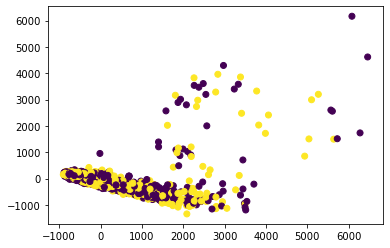

In [116]:
from sklearn.decomposition import PCA
pca = PCA()
t = pca.fit_transform(train_x)

plt.scatter(t[:,:1], t[:,1:2], c= train_y)
plt.show()

#### FastICA

c:\users\georg\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_fastica.py:120: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)


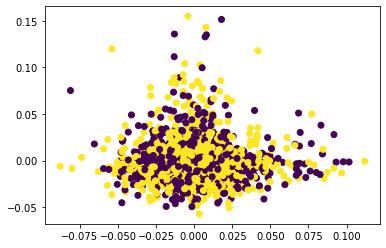

In [117]:
from sklearn.decomposition import FastICA

ica = FastICA()
t = ica.fit_transform(train_x)

plt.scatter(t[:,:1], t[:,1:2], c= train_y)
plt.show()

In [118]:
chroma = []
for i in dataframe.columns:
    if 'chroma' in i:
        chroma.append(i)
chroma_frame = dataframe[chroma].copy()
train_ch = chroma_frame[:split]
test_ch = chroma_frame[split:]
rfch = RandomForestClassifier()
rfch.fit(train_ch, train_y)
pred_ch = rfch.predict(test_ch)

accuracy=accuracy_(pred_ch, test_y)

Accuracy:  0.5134099616858238


#### SVM

In [119]:
from sklearn.svm import SVC
for i in ['poly', 'rbf', 'sigmoid']:
    print(i)
    clf = SVC(kernel=i)
    clf.fit(train_x, train_y)
    pred = clf.predict(test_x)
    accuracy=accuracy_(pred, test_y)

poly
Accuracy:  0.4386973180076628
rbf
Accuracy:  0.4559386973180077
sigmoid
Accuracy:  0.4578544061302682


In [120]:
# Distribution of major minor labels in the 4 quadrants
q1_ma = 0
q1_mi = 0
q2_ma = 0
q2_mi = 0
q3_ma = 0
q3_mi = 0
q4_ma = 0
q4_mi = 0

for ind, row in dataframe.iterrows():
    if row['quadrant'] == 1:
        if target[ind] == 1:
            q1_ma += 1
        else:
            q1_mi += 1
    elif row['quadrant'] == 2:
        if target[ind] == 1:
            q2_ma += 1
        else:
            q2_mi += 1
    elif row['quadrant'] == 3:
        if target[ind] == 1:
            q3_ma += 1
        else:
            q3_mi += 1
    elif row['quadrant'] == 4:
        if target[ind] == 1:
            q4_ma += 1
        else:
            q4_mi += 1
            
q1_ma, q1_mi, q2_ma, q2_mi, q3_ma, q3_mi, q4_ma, q4_mi

(228, 245, 151, 123, 724, 656, 224, 256)

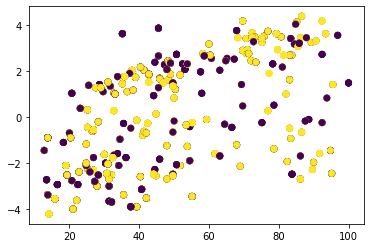

In [24]:
plt.scatter(dataframe['mean_A'], dataframe['mean_V'], c= target)